# Gradient Boosting Machines For Enhancer Activity Prediction


**Authorship:**
Adam Klie, *09/26/2021*
***
**Description:**
Notebook to train preliminary Gradient Boosting Machine classifiers for predicting enhancer activity
***
**TODOs:**
 - <font color='green'> Done TODO </font>
 - <font color='orange'> WIP TODO </font>
 - <font color='red'> Queued TODO </font>
***

In [13]:
# Classics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Loading webpages
from IPython.display import IFrame

import pickle

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

In [2]:
import sys
sys.path.append('/cellar/users/aklie/projects/EUGENE/bin/')
import project_utils

# Define parameters of the notebook

In [32]:
DATASET = "2021-OLS-Library"  # Which dataset to look at
FEATURES = "mixed-2.0"  # What features to use to train the model
PREPROCESS = "0.18-0.4"  # Preprocessing steps, separated by "-"
TRAIN = False
SUBSET = False

# Load data

In [33]:
X = np.loadtxt('../data/{0}/{1}/X_{2}_{3}.txt'.format(DATASET.replace("-", "_"), FEATURES.replace("-", "_"), FEATURES, PREPROCESS), delimiter=' ', dtype=float)
y = np.loadtxt('../data/{0}/y_binary_{1}.txt'.format(DATASET.replace("-", "_"), PREPROCESS), delimiter=' ', dtype=int)
X[0], y[0], X.shape, y.shape

(array([12. ,  0. ,  0. ,  0.9, -1. ,  2. ,  0.6,  1. ,  0. ,  0. ,  7. ,
         0.4,  1. ,  0. ,  0. ,  5. ,  0. ,  0. ,  0.3, -1. ,  0. ,  0. ,
         0. ,  0.5,  1. ,  0. ]),
 1,
 (302936, 26),
 (302936,))

# Train and test a gradient boosting classifier

## **Train/test split**

In [34]:
X_train, X_test, y_train, y_test = project_utils.split_train_test(X, y, split=0.9, subset=SUBSET)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((272642, 26), (30294, 26), (272642,), (30294,))

In [35]:
np.unique(y_train, return_counts=True)[1]/len(y_train), np.unique(y_test, return_counts=True)[1]/len(y_test)

(array([0.68878236, 0.31121764]), array([0.69115997, 0.30884003]))

## **Standardize features**: *For mixed encoding only*

In [36]:
if FEATURES in ["block", "ohe-seq"]:
    scale_indeces = []  # Block and one-hot
elif FEATURES in ["mixed-1.0"]:
    scale_indeces = np.array([0, 3, 4, 7, 8, 11, 12, 15, 16, 19, 20])  # Mixed 1.0
elif FEATURES in ["mixed-2.0"]:   
    scale_indeces = np.array([0, 5, 10, 15, 20, 25])  # Mixed 2.0

In [37]:
X_scaled_train, X_scaled_test = project_utils.standardize_features(train_X=X_train, test_X=X_test, indeces=scale_indeces)
X_train[:, scale_indeces].mean(axis=0), X_train[:, scale_indeces].std(axis=0)

(array([-3.72156537e-17, -8.61328681e-17,  6.50101178e-17,  5.79083912e-17,
         3.13779041e-17,  1.27648650e-16]),
 array([1., 1., 1., 1., 1., 1.]))

## **Gradient Boosting training**

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
HYPERPARAM = "selected"

#### <u> **Train new model from scratch using out-of-box or hand-crafted hyperparams** </u> 

In [42]:
if TRAIN == True and HYPERPARAM == "selected":
    clf = GradientBoostingClassifier(n_estimators=1000, random_state=13, verbose=1)
    print("Training new GBM with the following params: {}".format(clf.get_params()))
    clf.fit(X_train, y_train)

#### <u> **Train a new model using Optuna identified hyperparameters** </u>
TODO

#### <u> **Train new model using random search cross validation** </u> 
TODO

#### <u> **Get hyperpameters of model** </u>

In [44]:
if TRAIN == True:
    file = "{0}_{1}_GBM-clf_{2}.params.csv".format(PREPROCESS, FEATURES, HYPERPARAM)
    print("Saving hyperparams to".format(file))
    pd.DataFrame(pd.Series(clf.get_params())).T.to_csv(file, index=False)
    clf.get_params()

#### <u> **Load previously trained model** </u>

In [45]:
if TRAIN == False:
    file = '{}_{}_GBM-clf_{}.pickle'.format(PREPROCESS, FEATURES, HYPERPARAM)
    print("Loading model from {}".format(file))
    clf = pickle.load(open(file, 'rb'))

Loading model from 0.18-0.4_mixed-2.0_GBM-clf_selected.pickle


/cellar/users/aklie/opt/miniconda3/envs/scratch/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DummyClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/scratch/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/scratch/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


## **Gradient Boosting testing**

In [46]:
y_train_preds = clf.predict(X_train)
y_test_preds = clf.predict(X_test)

In [47]:
y_train_probs = clf.predict_proba(X_train)[:, 1]
y_test_probs = clf.predict_proba(X_test)[:, 1]

In [48]:
np.unique(y_train_preds, return_counts=True), np.unique(y_test_preds, return_counts=True)

((array([0, 1]), array([225806,  46836])),
 (array([0, 1]), array([25065,  5229])))

### <u>**Confusion matrices** </u>

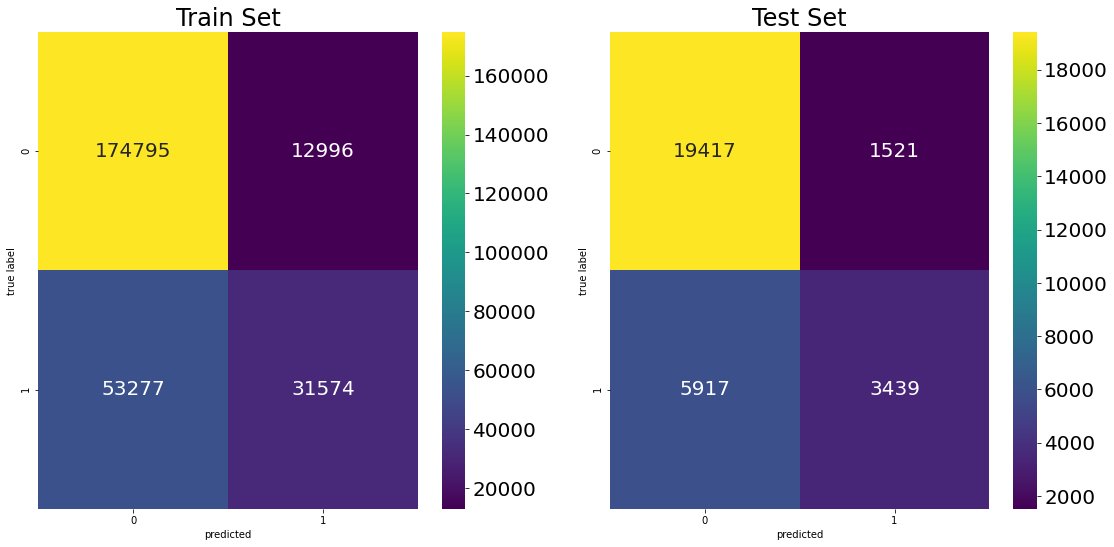

In [25]:
project_utils.train_test_confusion_matrix(train_y=y_train, 
                                          train_y_preds=y_train_preds, 
                                          test_y=y_test, 
                                          test_y_preds=y_test_preds, savefile="tmp.confusion.png")

### <u> **Classification Metrics** </u>

In [26]:
clf_metrics = project_utils.train_test_metrics(train_y=y_train, 
                                  train_y_preds=y_train_preds, 
                                  test_y=y_test, 
                                  test_y_preds=y_test_preds)

Metric	Train	Test
Accuracy	0.7569	0.7545
Precision	0.7084	0.6933
Recall	0.3721	0.3676
F0.1-Score	0.7021	0.6873
F0.5-Score	0.6000	0.5890
F1-Score	0.4879	0.4804
F2-Score	0.4111	0.4057
F10-Score	0.3739	0.3693


### <u> **Precision-recall** </u>

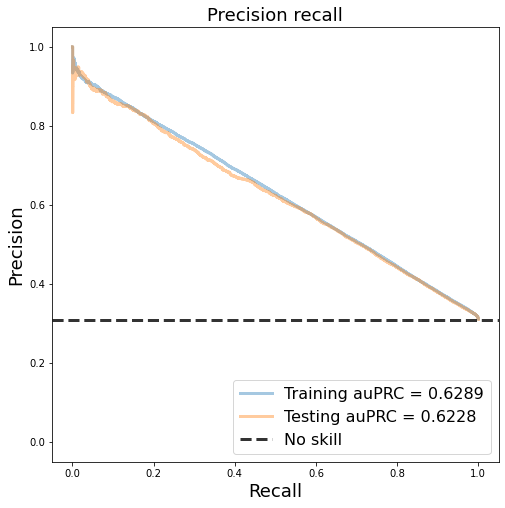

In [27]:
project_utils.train_test_pr_curve(train_y=y_train, 
                                  train_y_probs=y_train_probs, 
                                  test_y=y_test, 
                                  test_y_probs=y_test_probs,
                                   savefile="tmp.pr_curve.png")

### <u> **Reciever operating characteristic** </u>

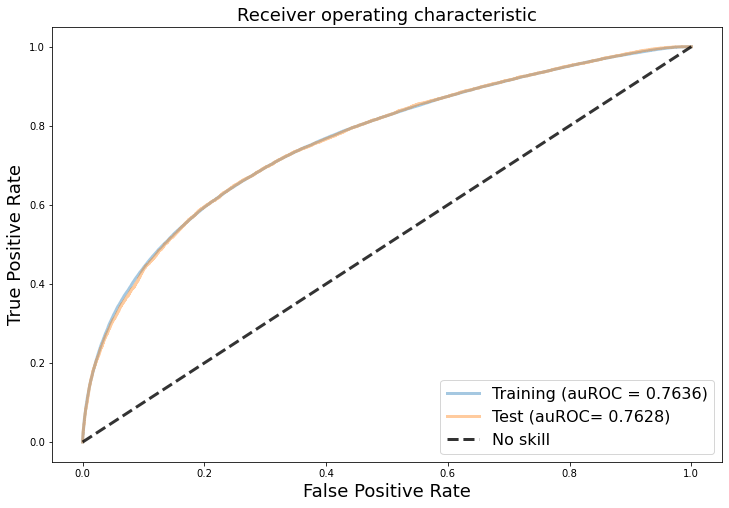

In [28]:
project_utils.train_test_roc_curve(train_y=y_train, 
                                   train_y_probs=y_train_probs, 
                                   test_y=y_test, 
                                   test_y_probs=y_test_probs,
                                   savefile="tmp.roc_curve.png")

## Save the classifier

In [192]:
file = '{0}_{1}_GBM-clf_{2}.pickle'.format(PREPROCESS, FEATURES, hyperparam)
pickle.dump(clf, open(file, 'wb'))

In [192]:
test_load = pickle.load(open(file, 'rb'))
np.unique(test_load.predict(X_test), return_counts=True)

# Scratch

In [74]:
from mdutils.mdutils import MdUtils
from mdutils import Html

In [103]:
mdFile = MdUtils(file_name='Example_Markdown', title='GBM Classification Report')

mdFile.new_header(level=1, title='Confusion Matrices')
mdFile.new_line(mdFile.new_inline_image(text="confusion_matrices", path="tmp.confusion.png"))
mdFile.new_line()

mdFile.new_header(level=1, title='Classification Metrics')
mdFile.new_table(columns=3, rows=9, text=clf_metrics, text_align='center')

mdFile.new_header(level=1, title='Precision-Recall Curve')
mdFile.new_line(mdFile.new_inline_image(text="pr_curve", path="tmp.pr_curve.png"))
mdFile.new_line()

mdFile.new_header(level=1, title='Reciever Operator Characteristic')
mdFile.new_line(mdFile.new_inline_image(text="roc_curve", path="tmp.roc_curve.png"))
mdFile.new_line()

mdFile.new_table_of_contents(table_title='Contents', depth=2)

mdFile.create_md_file()

Generating confusion matrix
Calculating classification metrics
Metric	Train	Test
Accuracy	0.7625	0.7621
Precision	0.7147	0.7055
Recall	0.3945	0.3943
F0.1-Score	0.7090	0.7000
F0.5-Score	0.6149	0.6093
F1-Score	0.5084	0.5059
F2-Score	0.4333	0.4324
F10-Score	0.3962	0.3960
Plotting PR Curve
Plotting ROC Curve
Generating report


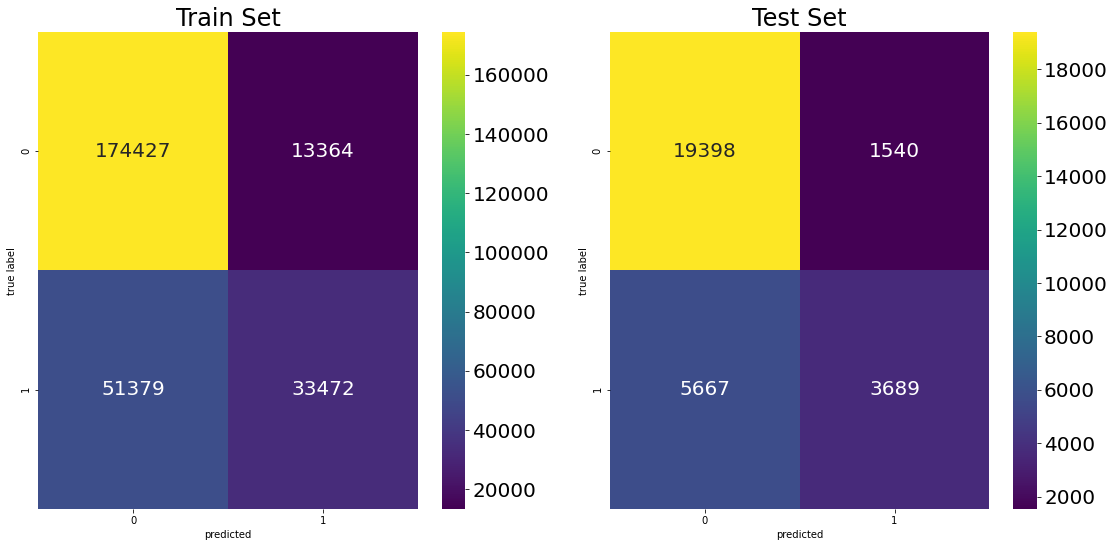

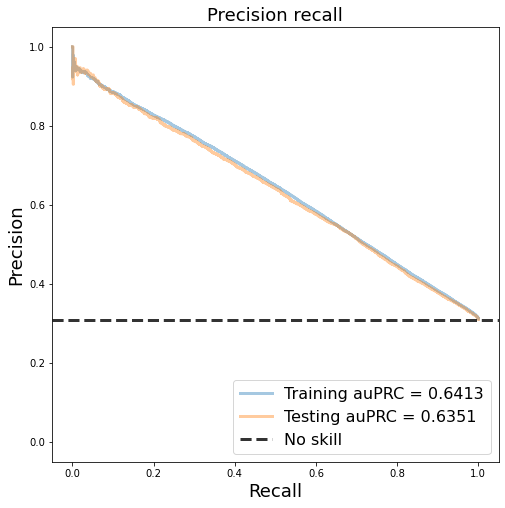

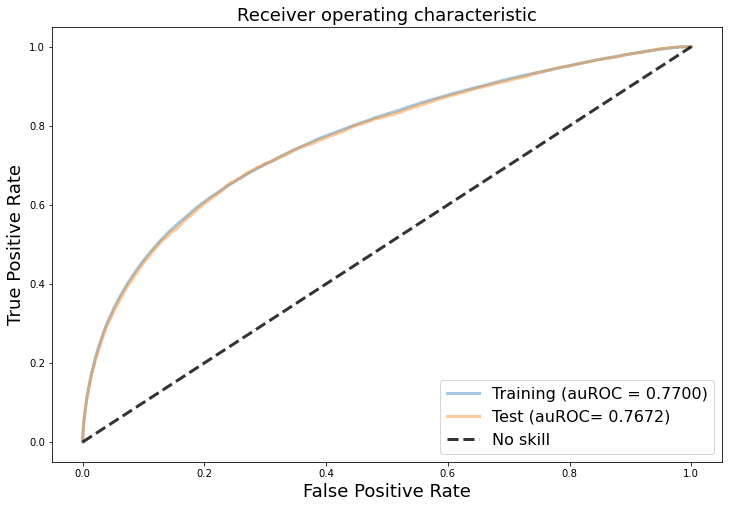

In [49]:
project_utils.classification_report(filename="{}_{}_{}_GBM-Classificaton-Report.md".format(PREPROCESS, FEATURES, HYPERPARAM),
                                    md_title="{}_{}_{}_GBM-Classificaton-Report".format(PREPROCESS, FEATURES, HYPERPARAM),
                                    clf=clf, train_X=X_train, test_X=X_test, train_y=y_train, test_y=y_test)
    